In [212]:
import simpy
import pandas as pd

from random import randint
import random

# Proyecto Simulacion de Atencion al Cliente

## Descripcion 
### En esta simulación, se aborda un problema de colas en el contexto de un sistema de atencion al cliente en una institución, donde varios clientes (usuarios) llegan de manera aleatoria para realizar sus tramites en una serie de ventanillas de servicio. Este tipo de problema es común en en diferentes lugares como: bancos, oficinas gubernamentales, centros de atención médica, entre otros, donde se tiene que hacer fila para poder ser atendidos.

## Objetivo
### Simular un sistema de atención al cliente en ventanillas para analizar el rendimiento y la eficiencia en la atención de tramites, mediante la implementación de un entorno de simulación con múltiples ventanillas y clientes utilizando simpy.

In [276]:
class Ventanilla:
    def __init__(self, env, name, speed_ppm, capacidad):
        self.env = env
        self.name = name
        self.speed_ppm = speed_ppm
        self.queue = simpy.Container(env, init=capacidad, capacity=capacidad) 
        self.resource = simpy.Resource(env, capacity=1)

        self.dfV = pd.DataFrame({
            "name": [name],
            "speed": [speed_ppm],
            "queue": [capacidad]
        })

        self.dfE = pd.DataFrame()

    def atender_cliente(self, num_solicitudes, client_name):
        if self.queue.level >= num_solicitudes:  
            yield self.queue.get(num_solicitudes)
            tiempo_atencion = num_solicitudes * self.speed_ppm
            yield self.env.timeout(tiempo_atencion)
            
            print(f"{self.env.now}: {self.name} atendió {num_solicitudes} solicitudes en {tiempo_atencion} minutos")
            df = pd.DataFrame({
                "time": [self.env.now],
                "ventanilla": [self.name],
                "cliente": [client_name],
                "evento": ["atención"]
            })

            self.dfE = pd.concat([self.dfE, df])
        else:
            print(f"{self.env.now}: {self.name} ha alcanzado su límite de solicitudes y no atenderá más clientes")
            df = pd.DataFrame({
                "time": [self.env.now],
                "ventanilla": [self.name],
                "cliente": [client_name],
                "evento": ["límite alcanzado de solicitudes"]
            })
            self.dfE = pd.concat([self.dfE, df])


In [278]:
class Cliente:
    def __init__(self, env, name, ventanilla, num_solicitudes):
        self.env = env
        self.name = name
        self.ventanilla = ventanilla
        self.num_solicitudes = num_solicitudes
        env.process(self.en_espera())

        self.dfC = pd.DataFrame({
            "name": [name],
            "ventanilla": [ventanilla.name],
            "num_solicitudes": [num_solicitudes]
        })

        self.dfE = pd.DataFrame()

    def en_espera(self):
        print(f"{self.env.now}: {self.name} está esperando para ser atendido en {self.ventanilla.name}")
        df = pd.DataFrame({
            "time": [self.env.now],
            "ventanilla": [self.ventanilla.name],
            "cliente": [self.name],
            "evento": ["en espera"]
        })
        self.dfE = pd.concat([self.dfE, df])
        with self.ventanilla.resource.request() as request:
            yield request
            print(f"{self.env.now}: {self.name} está listo para ser atendido en {self.ventanilla.name}")
            yield self.env.process(self.ventanilla.atender_cliente(self.num_solicitudes, self.name))
            print(f"{self.env.now}: {self.name} fue atendido en {self.ventanilla.name} con todas las solicitudes procesadas")
            df = pd.DataFrame({
                "time": [self.env.now],
                "ventanilla": [self.ventanilla.name],
                "cliente": [self.name],
                "evento": ["atendido"]
            })
            self.dfE = pd.concat([self.dfE, df])
            yield self.env.timeout(1)


In [280]:
class Configuración:
    def __init__(self, env, num_ventanillas, num_clientes):
        self.env = env
        self.clienteles = []
        self.num_clientes = num_clientes
        self.ventanillas = [Ventanilla(
            env,
            f"Ventanilla {i}",
            random.randint(1, 4), # velocidad con la que atienden
            random.randint(50, 60) # capacidad de solicitudes que pueden atender
        ) for i in range(num_ventanillas)]

        env.process(self.llegada_clientes())

    def llegada_clientes(self):
        for i in range(self.num_clientes):
            self.clienteles.append(Cliente(
                self.env,
                f"Cliente {i}",
                random.choice(self.ventanillas),
                random.randint(1, 3) # cantidad de solicitudes que realizan los clientes
            ))
            yield self.env.timeout(random.randint(1, 10))  # Los clientes llegan aleatoriamente entre 1 y 10 minutos

In [282]:
random.seed(111)

env = simpy.Environment()
config = Configuración(env, num_ventanillas=8, num_clientes=100)

env.run(until=480)  # Simula durante 8 horas

0: Cliente 0 está esperando para ser atendido en Ventanilla 6
0: Cliente 0 está listo para ser atendido en Ventanilla 6
4: Ventanilla 6 atendió 1 solicitudes en 4 minutos
4: Cliente 0 fue atendido en Ventanilla 6 con todas las solicitudes procesadas
6: Cliente 1 está esperando para ser atendido en Ventanilla 7
6: Cliente 1 está listo para ser atendido en Ventanilla 7
10: Ventanilla 7 atendió 1 solicitudes en 4 minutos
10: Cliente 1 fue atendido en Ventanilla 7 con todas las solicitudes procesadas
12: Cliente 2 está esperando para ser atendido en Ventanilla 3
12: Cliente 2 está listo para ser atendido en Ventanilla 3
18: Ventanilla 3 atendió 3 solicitudes en 6 minutos
18: Cliente 2 fue atendido en Ventanilla 3 con todas las solicitudes procesadas
20: Cliente 3 está esperando para ser atendido en Ventanilla 6
20: Cliente 3 está listo para ser atendido en Ventanilla 6
24: Ventanilla 6 atendió 1 solicitudes en 4 minutos
24: Cliente 3 fue atendido en Ventanilla 6 con todas las solicitudes p

## DataFrame de Ventanilla

In [284]:
df_events = pd.DataFrame()
df_ventanillas = pd.DataFrame()  

In [286]:
for v in config.ventanillas:
    df_ventanillas = pd.concat([df_ventanillas, v.dfV])
    df_events = pd.concat([df_events, v.dfE]) 

In [288]:
df_ventanillas

,name,speed,queue
0,Ventanilla 0,2,55
0,Ventanilla 1,4,53
0,Ventanilla 2,4,56
0,Ventanilla 3,2,60
0,Ventanilla 4,2,56
0,Ventanilla 5,2,52
0,Ventanilla 6,4,56
0,Ventanilla 7,4,54


## DataFrame de Cliente

In [290]:
df_clientes = pd.DataFrame()

In [292]:
for c in config.clienteles:
    df_clientes = pd.concat([df_clientes, c.dfC])
    df_events = pd.concat([df_events, c.dfE]) 

In [294]:
df_clientes

,name,ventanilla,num_solicitudes
0,Cliente 0,Ventanilla 6,1
0,Cliente 1,Ventanilla 7,1
0,Cliente 2,Ventanilla 3,3
0,Cliente 3,Ventanilla 6,1
0,Cliente 4,Ventanilla 1,2
...,...,...,...
0,Cliente 79,Ventanilla 1,3
0,Cliente 80,Ventanilla 3,3
0,Cliente 81,Ventanilla 3,2
0,Cliente 82,Ventanilla 7,1


In [296]:
df_events

,time,ventanilla,cliente,evento
0,48,Ventanilla 0,Cliente 7,atención
0,94,Ventanilla 0,Cliente 14,atención
0,184,Ventanilla 0,Cliente 31,atención
0,359,Ventanilla 0,Cliente 59,atención
0,466,Ventanilla 0,Cliente 77,atención
...,...,...,...,...
0,476,Ventanilla 3,Cliente 80,atendido
0,471,Ventanilla 3,Cliente 81,en espera
0,473,Ventanilla 7,Cliente 82,en espera
0,477,Ventanilla 7,Cliente 82,atendido


# Preguntas

## Cuantas son las solicitudes realizadas por cada ventanilla y numero de clientes atendidos

In [298]:
summVentanillas = df_clientes.groupby(
    ["ventanilla"], as_index=False
).agg({
    "num_solicitudes": ["sum"], 
    "name": ["count"]  # Cuenta cuántos clientes atendió cada ventanilla
})

summVentanillas

,ventanilla,num_solicitudes,name
,,sum,count
0,Ventanilla 0,10,5
1,Ventanilla 1,28,12
2,Ventanilla 2,16,7
3,Ventanilla 3,38,17
4,Ventanilla 4,22,9
5,Ventanilla 5,16,8
6,Ventanilla 6,28,13
7,Ventanilla 7,23,13


### La Ventanilla 3 realizo mas tramites y atendio mas clientes


## Cuantas personas esperaron mas de 60 minutos para ser atendidos

In [300]:
sample2 = df_events.sort_values(  ["cliente","time"]   )
sample2['lead'] = sample2.groupby('cliente')['time'].shift(-1)
sample2["time_on_event"] = sample2["lead"] - sample2["time"]

In [302]:
person_waiting = sample2.loc[ 
    ( sample2['time_on_event'] > 10 )
    &
    ( sample2['evento'] == "en espera" )
, : ]

person_waiting

,time,ventanilla,cliente,evento,lead,time_on_event
0,69,Ventanilla 1,Cliente 11,en espera,81.0,12.0
0,82,Ventanilla 7,Cliente 13,en espera,94.0,12.0
0,94,Ventanilla 7,Cliente 15,en espera,107.0,13.0
0,97,Ventanilla 2,Cliente 16,en espera,109.0,12.0
0,106,Ventanilla 6,Cliente 17,en espera,118.0,12.0
0,136,Ventanilla 1,Cliente 22,en espera,148.0,12.0
0,170,Ventanilla 1,Cliente 28,en espera,182.0,12.0
0,186,Ventanilla 6,Cliente 32,en espera,198.0,12.0
0,264,Ventanilla 1,Cliente 44,en espera,276.0,12.0
0,294,Ventanilla 2,Cliente 48,en espera,306.0,12.0


In [304]:
person_waiting.shape

(19, 6)

### 19 personas esperaron mas de 10 minutos para ser atendidas

## ¿Cuál fue el tiempo promedio de espera en la fila?

In [306]:
# Filtrar eventos de espera y finalización
df_waiting = df_events[df_events['evento'] == 'en espera'].copy()  # Filtra los eventos donde el cliente está esperando, y crea una copia del DataFrame
df_finished = df_events[df_events['evento'] == 'atención'].copy()  # Filtra los eventos donde el cliente ha sido atendido, y crea una copia del DataFrame

# Añadir columnas 'time_on_event' para registrar los tiempos de inicio y fin del evento
df_waiting['time_on_event'] = df_waiting['time']  # Registra el tiempo en que el cliente comenzó a esperar
df_finished['time_on_event'] = df_finished['time']  # Registra el tiempo en que el cliente terminó de esperar

# Unir los DataFrames de espera y finalización en función del 'cliente' para calcular los tiempos de espera
df_wait_times = pd.merge(df_waiting, df_finished, on='cliente', suffixes=('_en_espera', '_atendido'))

# Calcular el tiempo de espera para cada cliente
df_wait_times['waiting_time'] = df_wait_times['time_atendido'] - df_wait_times['time_en_espera']  # Calcula la diferencia entre el tiempo de atención y el tiempo de espera

# Calcular el tiempo promedio de espera
average_waiting_time = df_wait_times['waiting_time'].mean()  # Calcula el promedio de todos los tiempos de espera

print(f"El tiempo promedio de espera en la fila es: {average_waiting_time} minutos")  # Muestra el tiempo promedio de espera en minutos

El tiempo promedio de espera en la fila es: 6.901234567901234 minutos


## ¿Qué ventanilla fue más eficiente en términos de tiempo?

In [308]:
# Filtrar eventos de inicio y fin de servicio
df_start = df_events[df_events['evento'] == 'en espera'].copy()  # Filtra los eventos donde el cliente comienza el servicio
df_end = df_events[df_events['evento'] == 'atendido'].copy()  # Filtra los eventos donde el cliente termina el servicio

# Añadir columnas 'time_on_event' para registrar los tiempos de inicio y fin del servicio
df_start['time_on_event'] = df_start['time']  # Registra el tiempo en que el cliente comenzó el servicio
df_end['time_on_event'] = df_end['time']  # Registra el tiempo en que el cliente terminó el servicio

# Unir los DataFrames de inicio y fin en función del 'cliente' y 'ventanilla' para calcular los tiempos de servicio
df_service_times = pd.merge(df_start, df_end, on=['cliente', 'ventanilla'], suffixes=('_inicio', '_fin'))

# Calcular el tiempo de servicio para cada cliente
df_service_times['service_time'] = df_service_times['time_fin'] - df_service_times['time_inicio']  # Calcula la diferencia entre el tiempo de fin y el tiempo de inicio

# Calcular el tiempo promedio de servicio por ventanilla
average_service_time_per_ventanilla = df_service_times.groupby('ventanilla')['service_time'].mean().reset_index()  # Agrupa por ventanilla y calcula el promedio de 'service_time'

average_service_time_per_ventanilla.columns = ['ventanilla', 'average_service_time']  # Cambia nombres de columnas para mayor claridad

print("Tiempo promedio de servicio por ventanilla:")
average_service_time_per_ventanilla 

Tiempo promedio de servicio por ventanilla:


,ventanilla,average_service_time
0,Ventanilla 0,4.000000
1,Ventanilla 1,9.454545
2,Ventanilla 2,9.142857
3,Ventanilla 3,4.500000
4,Ventanilla 4,5.222222
5,Ventanilla 5,4.125000
6,Ventanilla 6,10.307692
7,Ventanilla 7,7.083333


La ventanilla que mas rapido atendia fue la ventanilla 0

La ventanilla que mas tardaba en atender fue la ventanilla 6

## ¿Cuántas solicitudes fueron atendidas en total en el sistema?

In [347]:
# Calcular el número total de solicitudes atendidas
total_requests_attended = df_clientes['num_solicitudes'].sum()

# Crear un DataFrame para almacenar el resultado
df_results = pd.DataFrame({
    'Metric': ['Total Requests Attended'],
    'Value': [total_requests_attended]
})

df_results

,Metric,Value
0,Total Requests Attended,181


In [349]:
print(f"El número total de solicitudes atendidas en el sistema es: {total_requests_attended}")

El número total de solicitudes atendidas en el sistema es: 181


##  ¿Cuál es la ventanilla con la mayor diferencia entre el tiempo de atención más largo y el más corto?

In [354]:
# Calcular la diferencia entre el tiempo de atención más largo y el más corto por ventanilla
time_range_per_ventanilla = df_service_times.groupby('ventanilla')['service_time'].agg(['max', 'min'])
time_range_per_ventanilla['time_range'] = time_range_per_ventanilla['max'] - time_range_per_ventanilla['min']

# Encontrar la ventanilla con la mayor diferencia de tiempo
max_time_range_ventanilla = time_range_per_ventanilla.loc[time_range_per_ventanilla['time_range'].idxmax()]

# Crear un DataFrame para almacenar el resultado
df_results = pd.DataFrame({
    'Ventanilla': [max_time_range_ventanilla.name],
    'Max Time': [max_time_range_ventanilla['max']],
    'Min Time': [max_time_range_ventanilla['min']],
    'Time Range': [max_time_range_ventanilla['time_range']]
})

df_results

,Ventanilla,Max Time,Min Time,Time Range
0,Ventanilla 6,17,4,13


In [356]:
print(f"La ventanilla con la mayor diferencia entre el tiempo de atención más largo y el más corto es {max_time_range_ventanilla.name} con una diferencia de {max_time_range_ventanilla['time_range']} minutos.")

La ventanilla con la mayor diferencia entre el tiempo de atención más largo y el más corto es Ventanilla 6 con una diferencia de 13 minutos.


## ¿Qué cliente experimentó el tiempo de espera más largo?

In [377]:
# Encontrar el cliente con el mayor tiempo de espera
max_waiting_client = df_wait_times.loc[df_wait_times['waiting_time'].idxmax()]

# Crear un DataFrame para almacenar el resultado
df_max_waiting = pd.DataFrame({
    'Cliente': [max_waiting_client['cliente']],
    'Tiempo de Espera': [max_waiting_client['waiting_time']]
})

# Mostrar el DataFrame
df_max_waiting

,Cliente,Tiempo de Espera
0,Cliente 72,17


In [362]:
print(f"El cliente que experimentó el tiempo de espera más largo es {max_waiting_client['cliente']} con un tiempo de espera de {max_waiting_client['waiting_time']} minutos.")

El cliente que experimentó el tiempo de espera más largo es Cliente 72 con un tiempo de espera de 17 minutos.


## ¿Cuál es el promedio de solicitudes por cliente en todo el sistema?

In [325]:
# Calcular el promedio de solicitudes por cliente
average_requests_per_client = df_clientes['num_solicitudes'].mean()

print(f"El promedio de solicitudes por cliente en todo el sistema es: {average_requests_per_client}")


El promedio de solicitudes por cliente en todo el sistema es: 2.1547619047619047


## ¿Cuántos clientes fueron atendidos por cada ventanilla en menos de 5 minutos?

In [329]:
clientes_atendidos_rapidamente = df_service_times[df_service_times['service_time'] < 5]

# Contar cuántos clientes fueron atendidos rápidamente por ventanilla
clientes_atendidos_por_ventanilla = clientes_atendidos_rapidamente.groupby('ventanilla')['cliente'].count().reset_index()
clientes_atendidos_por_ventanilla.columns = ['ventanilla', 'clientes_atendidos_en_menos_de_5_min']

clientes_atendidos_por_ventanilla

,ventanilla,clientes_atendidos_en_menos_de_5_min
0,Ventanilla 0,4
1,Ventanilla 1,2
2,Ventanilla 2,1
3,Ventanilla 3,7
4,Ventanilla 4,3
5,Ventanilla 5,7
6,Ventanilla 6,2
7,Ventanilla 7,6


Las ventanillas que atendieron mas clientes en menos de 5 minutos fue Ventanilla 3 y 5 

## ¿Cuál fue la distribución de tiempo de servicio por ventanilla?

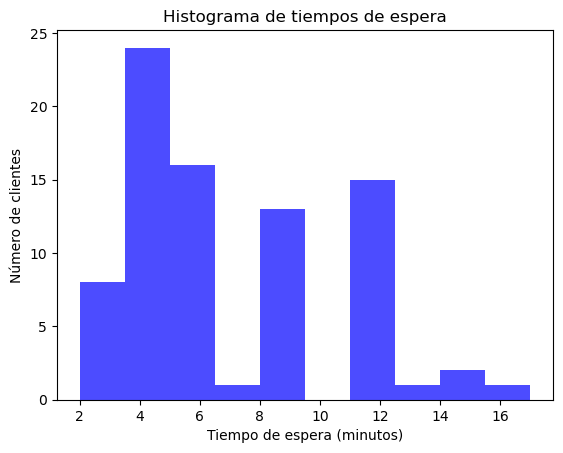

In [372]:
# Crear un histograma de los tiempos de espera
histograma_espera = df_wait_times['waiting_time'].plot(kind='hist', bins=10, color='blue', alpha=0.7)
histograma_espera.set_title('Histograma de tiempos de espera')
histograma_espera.set_xlabel('Tiempo de espera (minutos)')
histograma_espera.set_ylabel('Número de clientes')
plt.show()

## ¿Qué ventanilla tuvo más variabilidad en el tiempo de servicio?

In [366]:
# Calcular la desviación estándar del tiempo de servicio por ventanilla
variabilidad_servicio = df_service_times.groupby('ventanilla')['service_time'].std().reset_index()

# Encontrar la ventanilla con la mayor desviación estándar (más variable)
ventanilla_mas_variable = variabilidad_servicio.loc[variabilidad_servicio['service_time'].idxmax()]

# Crear un DataFrame para almacenar la ventanilla más variable y su desviación estándar
df_ventanilla_mas_variable = pd.DataFrame({
    'Ventanilla': [ventanilla_mas_variable['ventanilla']],
    'Desviación Estándar del Tiempo de Servicio': [ventanilla_mas_variable['service_time']]
})

df_ventanilla_mas_variable

,Ventanilla,Desviación Estándar del Tiempo de Servicio
0,Ventanilla 6,4.008005


La ventanilla con mas variabilidad en el tiempo fue la ventanilla 6